In [12]:
%%javascript
IPython.notebook.get_cells().map( function(c) {  return c.code_mirror.options.cursorBlinkRate=0;  } );
CodeMirror.defaults.cursorBlinkRate=0;

<IPython.core.display.Javascript object>

# COCOA Examples

Running COCOA using its docker image. If you haven't pulled the image yet, you can use

    docker pull --name cocoa ghcr.io/cocoa-hep/cocoa-hep:main
    docker tag ghcr.io/cocoa-hep/cocoa-hep:main cocoa
    sudo docker image rm ghcr.io/cocoa-hep/cocoa-hep:main

to do so and restart this notebook.

# Linux and permissions

On Linux you might need to prepare user permissions to run the docker client as done below. One way do do this is to

    sudo groupadd docker
    sudo gpasswd -a $USER docker
    newgrp docker

In [113]:
import docker

client = docker.from_env()

cmd1 = "cd /root/COCOA/COCOA"
cmd2 = "/root/COCOA/build/COCOA -c config/config_default.json -m macro/Pythia8/ChargedPion_monochromatic_isotropic.in -n 100 -o /root/COCOA/pions.root"
cmd3 = "cp /root/COCOA/pions.root /mnt/host_tmp"

command = 'bash -c "{} && {} && {}"'.format(cmd1, cmd2, cmd3)

In [114]:
def run_cocoa(command, volumes):
    container = client.containers.run("cocoa", command=command, volumes = volumes, detach = True)
    for line in container.logs(stream=True):
        print(line)

In [14]:
run_cocoa( command, ["/tmp:/mnt/host_tmp"] )

b'\n'
b'**************************************************************\n'
b' Geant4 version Name: geant4-10-07-patch-03    (19-November-2021)\n'
b'                       Copyright : Geant4 Collaboration\n'
b'                      References : NIM A 506 (2003), 250-303\n'
b'                                 : IEEE-TNS 53 (2006), 270-278\n'
b'                                 : NIM A 835 (2016), 186-225\n'
b'                             WWW : http://geant4.org/\n'
b'**************************************************************\n'
b'\n'
b'<<< Geant4 Physics List simulation engine: FTFP_BERT\n'
b'\n'
b'\n'
b' hInelastic FTFP_BERT : threshold between BERT and FTFP is over the interval \n'
b' for pions :   3 to 6 GeV\n'
b' for kaons :   3 to 6 GeV\n'
b' for proton :  3 to 6 GeV\n'
b' for neutron : 3 to 6 GeV\n'
b'\n'
b'### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0\n'
b'\n'
b' *------------------------------------------------------------------------------------

b'=======================================================================\n'
b'======       Pre-compound/De-excitation Physics Parameters     ========\n'
b'=======================================================================\n'
b'Type of pre-compound inverse x-section              3\n'
b'Pre-compound model active                           1\n'
b'Pre-compound excitation low energy (MeV)            0.1\n'
b'Pre-compound excitation high energy (MeV)           30\n'
b'Type of de-excitation inverse x-section             3\n'
b'Type of de-excitation factory                       Evaporation+GEM\n'
b'Number of de-excitation channels                    68\n'
b'Min excitation energy (keV)                         0.01\n'
b'Min energy per nucleon for multifragmentation (MeV) 2e+05\n'
b'Limit excitation energy for Fermi BreakUp (MeV)     20\n'
b'Level density (1/MeV)                               0.075\n'
b'Use simple level density model                      1\n'
b'Use discrete excitation energ

b'--> Event 3 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0    

b'--> Event 7 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0    

b'--> Event 11 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 15 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 19 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 23 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 27 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 31 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 35 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 39 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 43 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 47 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 51 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 55 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 59 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 63 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 67 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 71 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 75 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 79 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 83 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 87 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 91 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 95 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 99 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

In [95]:
macro_single_photon = open("/tmp/photon.in", "w")
macro_single_photon.write("/generator/select pythia8\n")
macro_single_photon.write("/generator/pythia8/verbose 0\n")
macro_single_photon.write("/tracking/storeTrajectory 1\n")
macro_single_photon.write("/generator/pythia8/QuarkGluon 22\n") # 22 = photon PDG id
macro_single_photon.write("/generator/pythia8/minEnergy 20\n")
macro_single_photon.write("/generator/pythia8/maxEnergy 20\n")
macro_single_photon.write("/generator/pythia8/minEta -2.5\n")
macro_single_photon.write("/generator/pythia8/maxEta 2.5\n")
macro_single_photon.write("/run/beamOn 10\n")
macro_single_photon.close()

cmd1 = "cp /mnt/host_tmp/photon.in /root/COCOA/COCOA"
cmd2 = "cd /root/COCOA/COCOA"
cmd3 = "/root/COCOA/build/COCOA -c config/config_default.json -m photon.in -n 100 -o /root/COCOA/photons.root"
cmd4 = "cp /root/COCOA/photons.root /mnt/host_tmp"

command = 'bash -c "{} && {} && {} && {}"'.format(cmd1, cmd2, cmd3, cmd4)

run_cocoa( command, ["/tmp:/mnt/host_tmp"] )

b'\n'
b'**************************************************************\n'
b' Geant4 version Name: geant4-10-07-patch-03    (19-November-2021)\n'
b'                       Copyright : Geant4 Collaboration\n'
b'                      References : NIM A 506 (2003), 250-303\n'
b'                                 : IEEE-TNS 53 (2006), 270-278\n'
b'                                 : NIM A 835 (2016), 186-225\n'
b'                             WWW : http://geant4.org/\n'
b'**************************************************************\n'
b'\n'
b'<<< Geant4 Physics List simulation engine: FTFP_BERT\n'
b'\n'
b'\n'
b' hInelastic FTFP_BERT : threshold between BERT and FTFP is over the interval \n'
b' for pions :   3 to 6 GeV\n'
b' for kaons :   3 to 6 GeV\n'
b' for proton :  3 to 6 GeV\n'
b' for neutron : 3 to 6 GeV\n'
b'\n'
b'### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0\n'
b'\n'
b' *------------------------------------------------------------------------------------

b'=======================================================================\n'
b'======       Pre-compound/De-excitation Physics Parameters     ========\n'
b'=======================================================================\n'
b'Type of pre-compound inverse x-section              3\n'
b'Pre-compound model active                           1\n'
b'Pre-compound excitation low energy (MeV)            0.1\n'
b'Pre-compound excitation high energy (MeV)           30\n'
b'Type of de-excitation inverse x-section             3\n'
b'Type of de-excitation factory                       Evaporation+GEM\n'
b'Number of de-excitation channels                    68\n'
b'Min excitation energy (keV)                         0.01\n'
b'Min energy per nucleon for multifragmentation (MeV) 2e+05\n'
b'Limit excitation energy for Fermi BreakUp (MeV)     20\n'
b'Level density (1/MeV)                               0.075\n'
b'Use simple level density model                      1\n'
b'Use discrete excitation energ

b'--> Event 3 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0    

b'--> Event 7 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0    

b'--> Event 11 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 15 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 19 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 23 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 27 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 31 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 35 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 39 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 43 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 47 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 51 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 55 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 59 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 63 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 67 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 71 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 75 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 79 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 83 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 87 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 91 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 95 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

b'--> Event 99 starts.\n'
b'\n'
b' *-------  PYTHIA Flag + Mode + Parm + Word + FVec + MVec + PVec + WVec Settings (changes only)  ------------------* \n'
b' |                                                                                                                 | \n'
b' | Name                                          |                      Now |      Default         Min         Max | \n'
b' |                                               |                          |                                      | \n'
b' | HardQCD:all                                   |                       on |          off                         | \n'
b' | Next:numberShowEvent                          |                        0 |            1           0             | \n'
b' | Next:numberShowInfo                           |                        0 |            1           0             | \n'
b' | Next:numberShowProcess                        |                        0 |            1           0   

# Example plots: cell vs. particle energy, $\eta$ and $\varphi$

In [108]:
import numpy as np
import uproot

# code duplication : to be made more efficient and safe

pions_tree        = uproot.open("/tmp/pions.root:Out_Tree")
pions_cell_e      = pions_tree.arrays( [ "cell_e" ], library = "np" )
pions_n_particles = pions_cell_e["cell_e"].shape[0]
pions_particle_e  = tree.arrays( [ "particle_e" ], library = "np" )
pions_residual_e = [ pions_cell_e["cell_e"][i_prt].sum() / pions_particle_e["particle_e"][i_prt][0] - 1.0 for i_prt in range(pions_n_particles)]

photons_tree        = uproot.open("/tmp/photons.root:Out_Tree")
photons_cell_e      = photons_tree.arrays( [ "cell_e" ], library = "np" )
photons_n_particles = photons_cell_e["cell_e"].shape[0]
photons_particle_e  = tree.arrays( [ "particle_e" ], library = "np" )
photons_residual_e = [ photons_cell_e["cell_e"][i_prt].sum() / photons_particle_e["particle_e"][i_prt][0] - 1.0 for i_prt in range(photons_n_particles)]

In [111]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 6.0)  # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"
plt.rcParams["figure.facecolor"] = "White"
plt.rcParams["font.size"] = 12

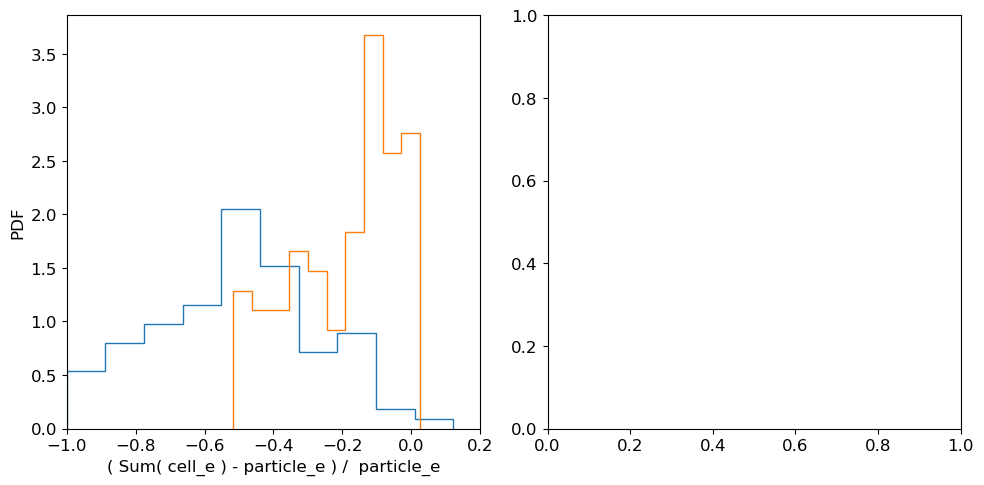

In [118]:
plt.hist(
         pions_residual_e,
         histtype="step",
         density=True,
)
ax = plt.gca()
ax.set(xlabel="( Sum( cell_e ) - particle_e ) /  particle_e", ylabel="PDF")
ax.set_xlim(-1.0, 0.2)

ax = plt.subplot(1, 2, 1)
plt.hist(
         photons_residual_e,
         histtype="step",
         density=True,
)
ax.set(xlabel="( Sum( cell_e ) - particle_e ) /  particle_e", ylabel="PDF")
ax.set_xlim(-1.0, 0.2)

plt.tight_layout()
plt.show()